# Clustering Smartphone Cases

## Preparation

In [1]:
import itertools

import matplotlib as mpl
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, silhouette_score

from src import akeneo, akeneo_clustering as ac, clustering, config

In [2]:
cache = akeneo.create_cache_from_env()

In [3]:
data_dir = config.dir_data / "clustering-results" / "2-phones"
data_dir.mkdir(parents=True, exist_ok=True)

In [25]:
mpl.rcParams['figure.dpi'] = 300

family = "smartphones"
channel = "default"
lang = "en_US"

### Products

In [5]:
products = ac.parse_products(
    cache,
    product_families=[family],
    attribute_types=ac.TYPES_NUMERICAL + ac.TYPES_CATEGORICAL + ac.TYPES_MULTI + ac.TYPES_TEXT,
)
products_multi_as_single = ac.transform_multi_to_single_cat(products)

n = len(products)

products_df = pd.DataFrame(products)
products_multi_as_single_df = pd.DataFrame(products_multi_as_single)

In [6]:
labels_want_generations = products_df["__categories__"].map(lambda x: x[-1].split("_")[0]).to_numpy()
k_generations = len(set(labels_want_generations))
pd.Series(labels_want_generations).value_counts(), f"k = {k_generations}"

(s21    21
 s20    17
 s22     4
 dtype: int64,
 'k = 3')

In [7]:
labels_want_models = products_df["__categories__"].map(lambda x: x[-1]).to_numpy()
k_models = len(set(labels_want_models))
pd.Series(labels_want_models).value_counts(), f"k = {k_models}"

(s21          7
 s21_ultra    6
 s20          5
 s20_plus     5
 s20_ultra    4
 s21_plus     4
 s21_fe       4
 s20_fe       3
 s22          2
 s22_plus     1
 s22_ultra    1
 dtype: int64,
 'k = 11')

In [8]:
duplicates: dict[str, list[int]] = {}
for index, categories in products_df.to_dict()[ac.KEY_CATEGORIES].items():
    category = categories[0]
    if category[:4] != "dup_":
        continue

    if category not in duplicates:
        duplicates[category] = []
    duplicates[category].append(index)
duplicates

{'dup_s20': [1, 2],
 'dup_s20_ultra': [9, 10],
 'dup_s21_128': [18, 19],
 'dup_s21_256': [20, 21],
 'dup_s21_plus': [24, 25],
 'dup_s21_ultra': [32, 33]}

### Attributes

In [9]:
tmp = {
    "code": [],
    "name": [],
    "type": [],
    "typeclass": [],
    "required": [],
    "non-null": [],
    "unique": [],
}

attr_req = list(filter(lambda f: f.code == family, cache.families))[0].attribute_requirements[channel]

for attr_code, attr in akeneo.Attribute.to_dict(cache.attributes).items():
    if attr_code not in products_df.columns:
        continue

    typeclass = (
        "numerical"
        if attr.type in ac.TYPES_NUMERICAL
        else "categorical"
        if attr.type in ac.TYPES_CATEGORICAL
        else "multi"
        if attr.type in ac.TYPES_MULTI
        else "string"
        if attr.type in ac.TYPES_TEXT
        else "unknown"
    )

    tmp["code"].append(attr_code)
    tmp["name"].append(attr.labels[lang])
    tmp["type"].append(attr.type)
    tmp["typeclass"].append(typeclass)
    tmp["required"].append(attr_code in attr_req)
    tmp["non-null"].append(products_df[attr_code].count())
    tmp["unique"].append(products_df[attr_code].drop_duplicates().count())

attr_df = pd.DataFrame(tmp)
attr_df.sort_values(["required", "non-null"], ascending=[False, False])

,code,name,type,typeclass,required,non-null,unique
10,icecat_12435_fixed,Rear camera resolution (numeric),AttributeType.NUMBER,numerical,True,42,4
11,icecat_12437_fixed,Front camera resolution (numeric),AttributeType.NUMBER,numerical,True,42,3
25,icecat_1585,Display resolution,AttributeType.TEXT,string,True,42,4
37,icecat_1766_fixed,Product color,AttributeType.SELECT_MULTI,multi,True,42,15
64,icecat_27587,Rear camera type,AttributeType.SELECT_SINGLE,categorical,True,42,2
...,...,...,...,...,...,...,...
108,icecat_3807,Package height,AttributeType.METRIC,numerical,False,1,1
109,icecat_3808,Package width,AttributeType.METRIC,numerical,False,1,1
112,icecat_38332,Heart rate sensor,AttributeType.BOOL,categorical,False,1,1
137,icecat_4857,Battery weight,AttributeType.METRIC,numerical,False,1,1


In [10]:
cols = ["code", "typeclass", "required", "non-null", "unique"]
attr_df[cols].groupby(["typeclass", "required"]).agg({
    "code": "count",
    "non-null": "mean",
    "unique": "mean",
}).reset_index().round(1)

,typeclass,required,code,non-null,unique
0,categorical,False,87,26.1,1.2
1,categorical,True,19,37.9,1.6
2,multi,False,19,23.1,2.9
3,multi,True,3,38.7,7.0
4,numerical,False,48,18.5,3.5
5,numerical,True,8,41.1,5.4
6,string,False,6,18.0,4.8
7,string,True,5,40.8,24.0


### Clustering & Metrics

In [11]:
def _calc_duplicates_match(labels) -> float:
    result = 0.0
    n_duplicates = 0
    for _, indexes in duplicates.items():
        y1 = labels[indexes[0]]
        y2 = labels[indexes[1]]

        shared_clusters = len(y1.intersection(y2))
        all_clusters = len(y1.union(y2))

        result += (shared_clusters+1) / all_clusters
        n_duplicates += 1
    
    return result / n_duplicates

def calc_metrics(attr_codes, multi_as_single=False, attr_to_overweight: list[str] = None, factor = 2):
    dataset = (
        ac.dataset_from_records(products_df[attr_codes].to_dict("records"))
        if not multi_as_single
        else ac.dataset_from_records(products_multi_as_single_df[attr_codes].to_dict("records"))
    )
    prox_matrix = ac.calc_proximity_matrix(dataset)

    if attr_to_overweight is not None:
        dataset = ac.overweight_attributes(dataset, attr_to_overweight, factor)

    bik = clustering.BisectingKMeans(dataset, ac.Centroid, random_state=0)
    biks = [
        clustering.BisectingKMeans(dataset, ac.Centroid, random_state=i)
        for i in range(1, 11)
    ]

    stabilities = []
    for k in range(2, len(dataset) + 1):
        values = []
        for bikk in biks:
            values.append(
                adjusted_rand_score(
                    bik.labels_flat(k),
                    bikk.labels_flat(k),
                )
            )
        stabilities.append(np.array(values).mean())
    stabilities = np.array(stabilities)

    qualities = []
    for k in range(2, len(dataset)):
        qualities.append(silhouette_score(prox_matrix, bik.labels_flat(k), metric="precomputed"))
    qualities = np.array(qualities)

    return {
        "stabilities": stabilities,
        "qualities": qualities,
        "match_gen": adjusted_rand_score(labels_want_generations, bik.labels_flat(k_generations)),
        "match_mod": adjusted_rand_score(labels_want_models, bik.labels_flat(k_models)),
        "match_dup": _calc_duplicates_match(bik.labels)
    }

In [12]:
def metrics_to_table(metric):
    return {
        "Stability": metric["stabilities"].mean(),
        "Quality": metric["qualities"].mean(),
        "Match Generations": metric["match_gen"],
        "Match Models": metric["match_mod"],
        "Match Duplicates": metric["match_dup"],
    }

## Clusterings

### Evaluate Multi-Categorical

In [13]:
attr_codes_mul = attr_df[(attr_df["typeclass"] == "multi")]["code"].to_list()
attr_codes_mul_req = attr_df[(attr_df["typeclass"] == "multi") & attr_df["required"]]["code"].to_list()
attr_codes_str = attr_df[(attr_df["typeclass"] == "string")]["code"].to_list()
attr_codes_str_req = attr_df[(attr_df["typeclass"] == "string") & attr_df["required"]]["code"].to_list()

cols = ["code", "typeclass", "required"]
attr_df[attr_df["code"].isin(attr_codes_mul+attr_codes_str)][cols].groupby(cols[1:]).count()

code
typeclass required      
multi     False       19
          True         3
string    False        6
          True         5

In [14]:
attr_df[attr_df["typeclass"] == "multi"]

,code,name,type,typeclass,required,non-null,unique
14,icecat_13248_fixed,Social network services supported,AttributeType.SELECT_MULTI,multi,False,3,2
18,icecat_14695_fixed,4G bands supported,AttributeType.SELECT_MULTI,multi,False,8,7
19,icecat_1503_fixed,Modulation,AttributeType.SELECT_MULTI,multi,False,2,1
33,icecat_16923_fixed,3G standards,AttributeType.SELECT_MULTI,multi,True,40,4
35,icecat_1742_fixed,USB connector type,AttributeType.SELECT_MULTI,multi,False,40,1
37,icecat_1766_fixed,Product color,AttributeType.SELECT_MULTI,multi,True,42,15
44,icecat_1809_fixed,Voice codecs,AttributeType.SELECT_MULTI,multi,False,2,1
47,icecat_1830_fixed,Cables included,AttributeType.SELECT_MULTI,multi,False,37,2
56,icecat_2224_fixed,Audio formats supported,AttributeType.SELECT_MULTI,multi,False,38,7
74,icecat_2963_fixed,Resolution at capture speed,AttributeType.SELECT_MULTI,multi,False,37,5


In [15]:
attr_df[attr_df["typeclass"] == "string"]

,code,name,type,typeclass,required,non-null,unique
9,icecat_12434,Rear camera resolution,AttributeType.TEXT,string,False,18,4
25,icecat_1585,Display resolution,AttributeType.TEXT,string,True,42,4
26,icecat_1597,Video capture resolution (max),AttributeType.TEXT,string,False,40,2
40,icecat_17956,Color name,AttributeType.TEXT,string,False,35,19
57,icecat_23731,Harmonized System (HS) code,AttributeType.TEXT,string,False,1,1
84,icecat_34,Contrast ratio (typical),AttributeType.TEXT,string,False,2,1
103,icecat_36920,Rear camera sensor size,AttributeType.TEXT,string,False,12,2
191,icecat_description_short,Short Description,AttributeType.TEXT,string,True,36,16
192,icecat_name,Name,AttributeType.TEXT,string,True,42,24
193,icecat_summary_short,Short Summary,AttributeType.TEXT,string,True,42,38


In [16]:
def metrics_mul_make():
    return {
        "multi": calc_metrics(attr_codes_mul),
        "multi as single": calc_metrics(attr_codes_mul, True),
        "multi req": calc_metrics(attr_codes_mul_req),
        "multi req as single": calc_metrics(attr_codes_mul_req, True),
        "string as multi": calc_metrics(attr_codes_str),
        "string as single": calc_metrics(attr_codes_str, True),
        "string req as multi": calc_metrics(attr_codes_str_req),
        "string req as single": calc_metrics(attr_codes_str_req, True),
    }
metrics_mul = config.load_or_create(data_dir / "metrics-mul.pkl", metrics_mul_make)

In [17]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_mul.items()
}).transpose().round(2)

,Stability,Quality,Match Generations,Match Models,Match Duplicates
multi,0.91,0.39,0.40,0.45,0.89
multi as single,0.85,0.38,0.12,0.30,0.88
multi req,0.70,0.38,0.51,0.24,0.86
multi req as single,0.64,0.40,0.44,0.25,0.82
string as multi,0.91,0.34,0.64,0.87,1.00
string as single,0.80,0.23,0.14,0.58,1.00
string req as multi,0.94,0.37,0.17,0.53,0.96
string req as single,0.82,0.22,0.30,0.69,0.97


In [18]:
tmp = {
    "num+cat": attr_df[attr_df["typeclass"].isin(["numerical", "categorical"])]["code"],
    "num+cat+mul": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "multi"])]["code"],
    "num+cat+str": attr_df[attr_df["typeclass"].isin(["numerical", "categorical", "string"])]["code"],
}

def metrics_mul_plus_make():
    return {
        "num+cat": calc_metrics(tmp["num+cat"]),
        "num+cat+mul": calc_metrics(tmp["num+cat+mul"]),
        "num+cat+mul as cat": calc_metrics(tmp["num+cat+mul"], True),
        "num+cat+str": calc_metrics(tmp["num+cat+str"]),
        "num+cat+str as cat": calc_metrics(tmp["num+cat+str"], True),
    }
metrics_mul_plus = config.load_or_create(data_dir / "metrics-mul-plus.pkl", metrics_mul_plus_make)

In [19]:
pd.DataFrame({
    key: metrics_to_table(met)
    for key, met in metrics_mul_plus.items()
}).transpose().round(2)

,Stability,Quality,Match Generations,Match Models,Match Duplicates
num+cat,0.98,0.43,0.65,0.71,0.96
num+cat+mul,0.98,0.41,0.16,0.70,0.97
num+cat+mul as cat,0.97,0.40,0.52,0.68,0.96
num+cat+str,0.98,0.41,0.65,0.66,0.96
num+cat+str as cat,0.97,0.38,0.65,0.66,0.96


### Evaluate Type Classes

In [20]:
tmp = ["numerical", "categorical", "multi", "string"]
attr_codes_types = {
    **{
        t: attr_df[attr_df["typeclass"]==t]["code"].to_list()
        for t in tmp
    },
    **{
        f"{t1[:3]}+{t2[:3]}": attr_df[attr_df["typeclass"].isin([t1, t2])]["code"].to_list()
        for t1, t2 in itertools.combinations(tmp, 2)
    },
    **{
        f"{t1[:3]}+{t2[:3]}+{t3[:3]}": attr_df[attr_df["typeclass"].isin([t1, t2, t3])]["code"].to_list()
        for t1, t2, t3 in itertools.combinations(tmp, 3)
    },
    "num+cat+mul+str": attr_df[attr_df["typeclass"].isin(tmp)]["code"].to_list(),
}
pd.DataFrame([(key, value) for key, value in attr_codes_types.items()])

,0,1
0,numerical,"[icecat_11379, icecat_12435_fixed, icecat_1243..."
1,categorical,"[icecat_10157, icecat_1024_fixed, icecat_10399..."
2,multi,"[icecat_13248_fixed, icecat_14695_fixed, iceca..."
3,string,"[icecat_12434, icecat_1585, icecat_1597, iceca..."
4,num+cat,"[icecat_10157, icecat_1024_fixed, icecat_10399..."
5,num+mul,"[icecat_11379, icecat_12435_fixed, icecat_1243..."
6,num+str,"[icecat_11379, icecat_12434, icecat_12435_fixe..."
7,cat+mul,"[icecat_10157, icecat_1024_fixed, icecat_10399..."
8,cat+str,"[icecat_10157, icecat_1024_fixed, icecat_10399..."
9,mul+str,"[icecat_12434, icecat_13248_fixed, icecat_1469..."


In [21]:
def metrics_types_make():
    return {
        key: calc_metrics(value)
        for key, value in attr_codes_types.items()
    }
metrics_types = config.load_or_create(data_dir / "metrics-types.pkl", metrics_types_make)

In [22]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_types.items()
}).transpose().style.highlight_max(color="lightgreen")

,Stability,Quality,Match Generations,Match Models,Match Duplicates
numerical,0.881189,0.432505,0.006612,0.754644,0.958333
categorical,0.956386,0.451987,0.652655,0.488721,0.813889
multi,0.907165,0.388965,0.397837,0.452215,0.891667
string,0.912915,0.338833,0.642564,0.871639,1.000000
num+cat,0.979872,0.425714,0.652655,0.711868,0.958333
num+mul,0.936747,0.394896,0.158205,0.703540,1.000000
num+str,0.927798,0.378513,0.006612,0.668020,0.966667
cat+mul,0.887588,0.388018,0.109726,0.488721,0.925000
cat+str,0.990783,0.399981,0.652655,0.424574,0.944444
mul+str,0.851166,0.319563,0.371828,0.489165,1.000000


In [23]:
pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_types.items()
}).transpose().round(2)

,Stability,Quality,Match Generations,Match Models,Match Duplicates
numerical,0.88,0.43,0.01,0.75,0.96
categorical,0.96,0.45,0.65,0.49,0.81
multi,0.91,0.39,0.40,0.45,0.89
string,0.91,0.34,0.64,0.87,1.00
num+cat,0.98,0.43,0.65,0.71,0.96
num+mul,0.94,0.39,0.16,0.70,1.00
num+str,0.93,0.38,0.01,0.67,0.97
cat+mul,0.89,0.39,0.11,0.49,0.92
cat+str,0.99,0.40,0.65,0.42,0.94
mul+str,0.85,0.32,0.37,0.49,1.00


<AxesSubplot:title={'center':'Quality'}, xlabel='k'>

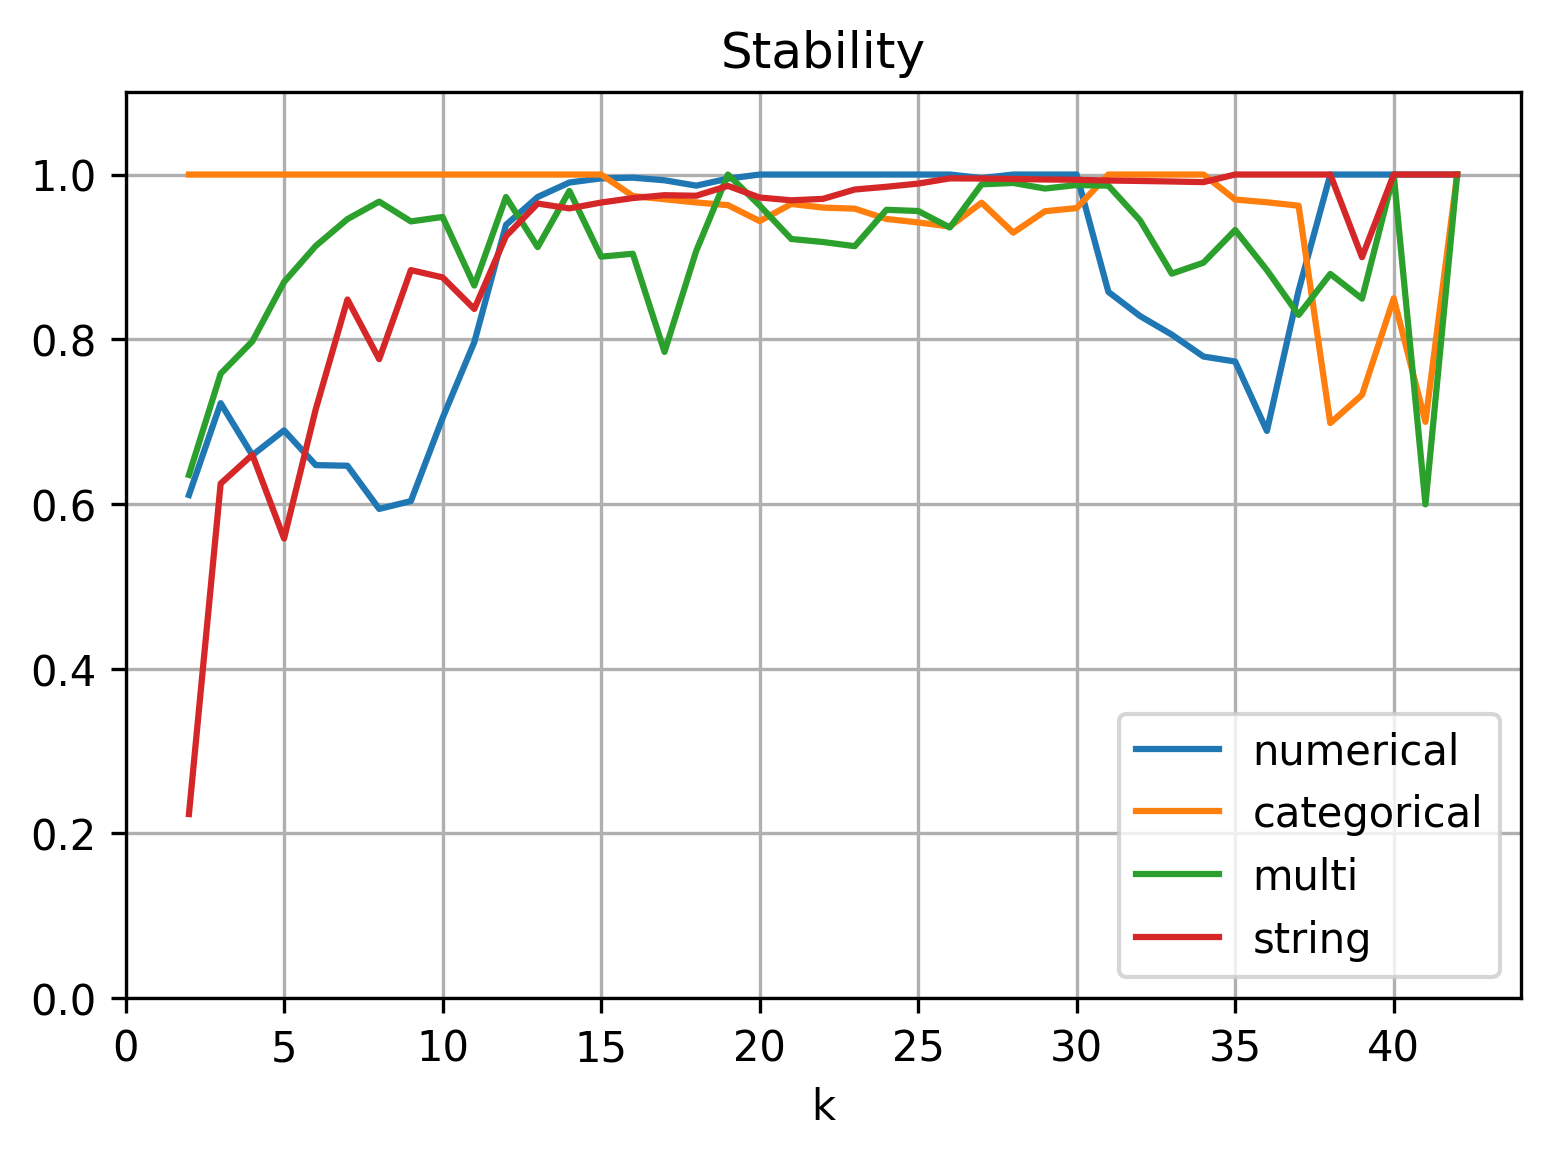

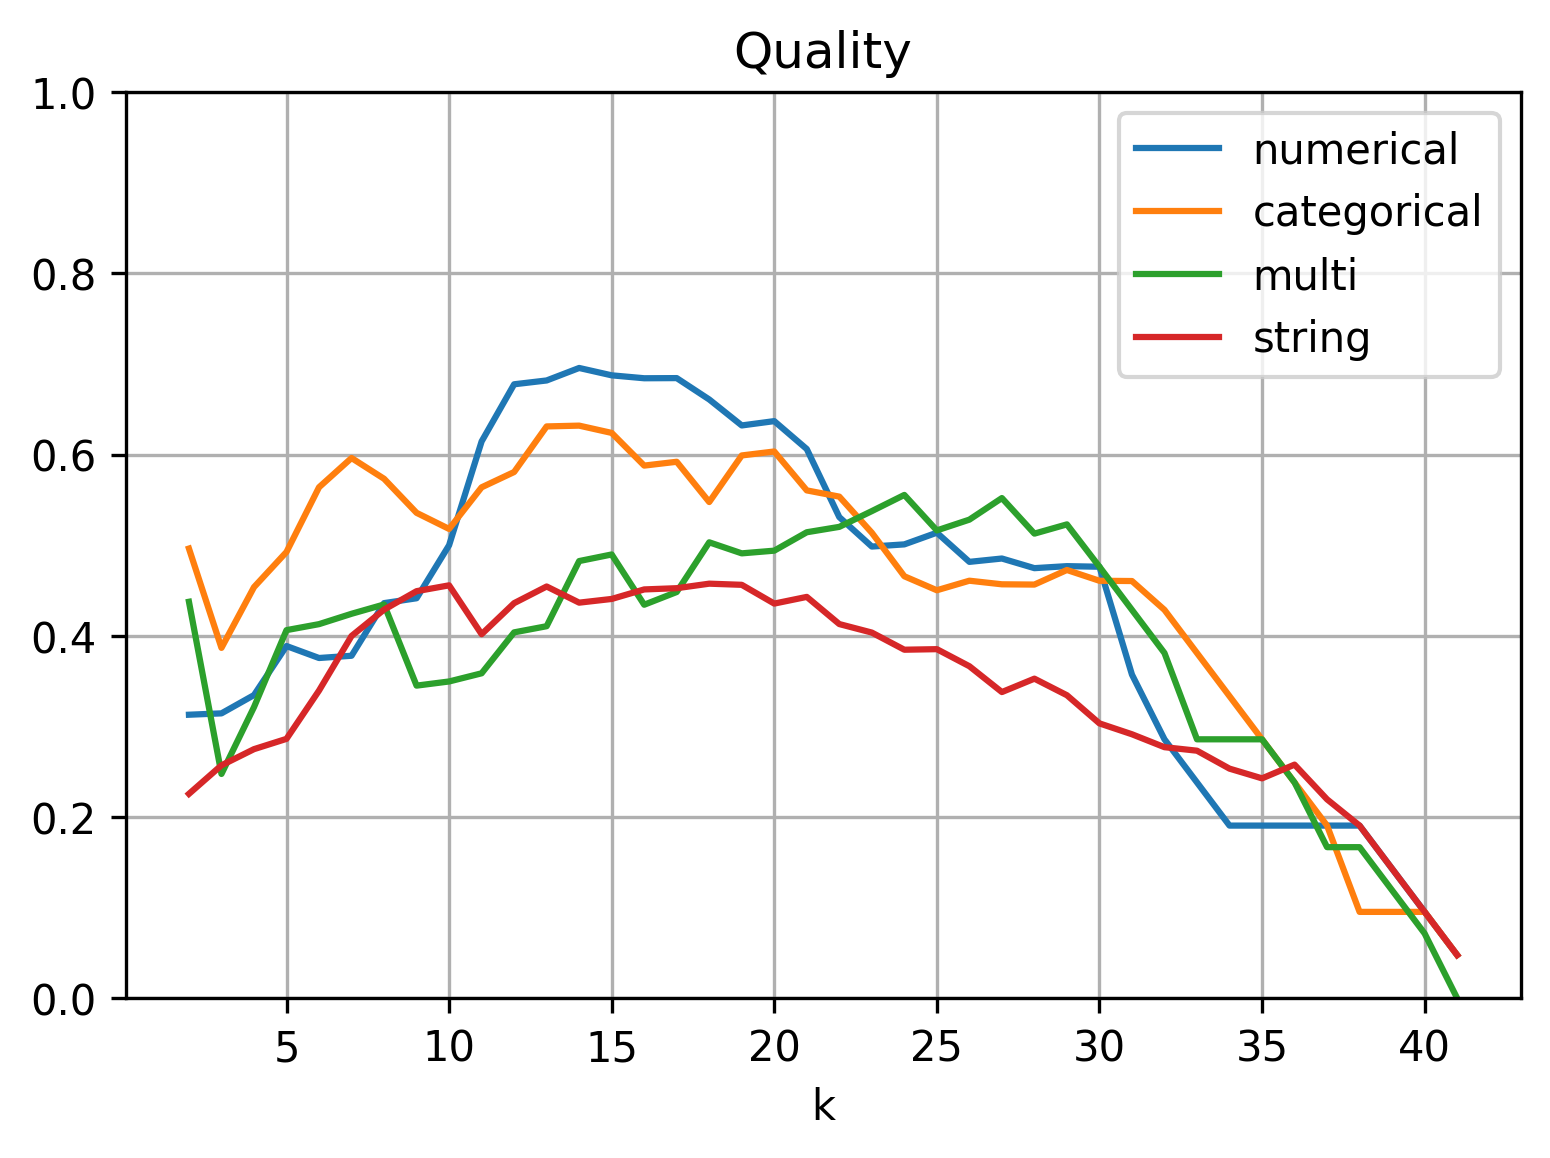

In [27]:
combis = ["numerical", "categorical", "multi", "string"]

pd.DataFrame({
    key: metrics_types[key]["stabilities"]
    for key in combis
}, index=range(2, n+1)).plot.line(title="Stability", ylim=(0,1.1), xlabel="k", grid=True)
pd.DataFrame({
    key: metrics_types[key]["qualities"]
    for key in combis
}, index=range(2, n)).plot.line( title="Quality", ylim=(0,1), xlabel="k", grid=True)

<AxesSubplot:title={'center':'Quality'}, xlabel='k'>

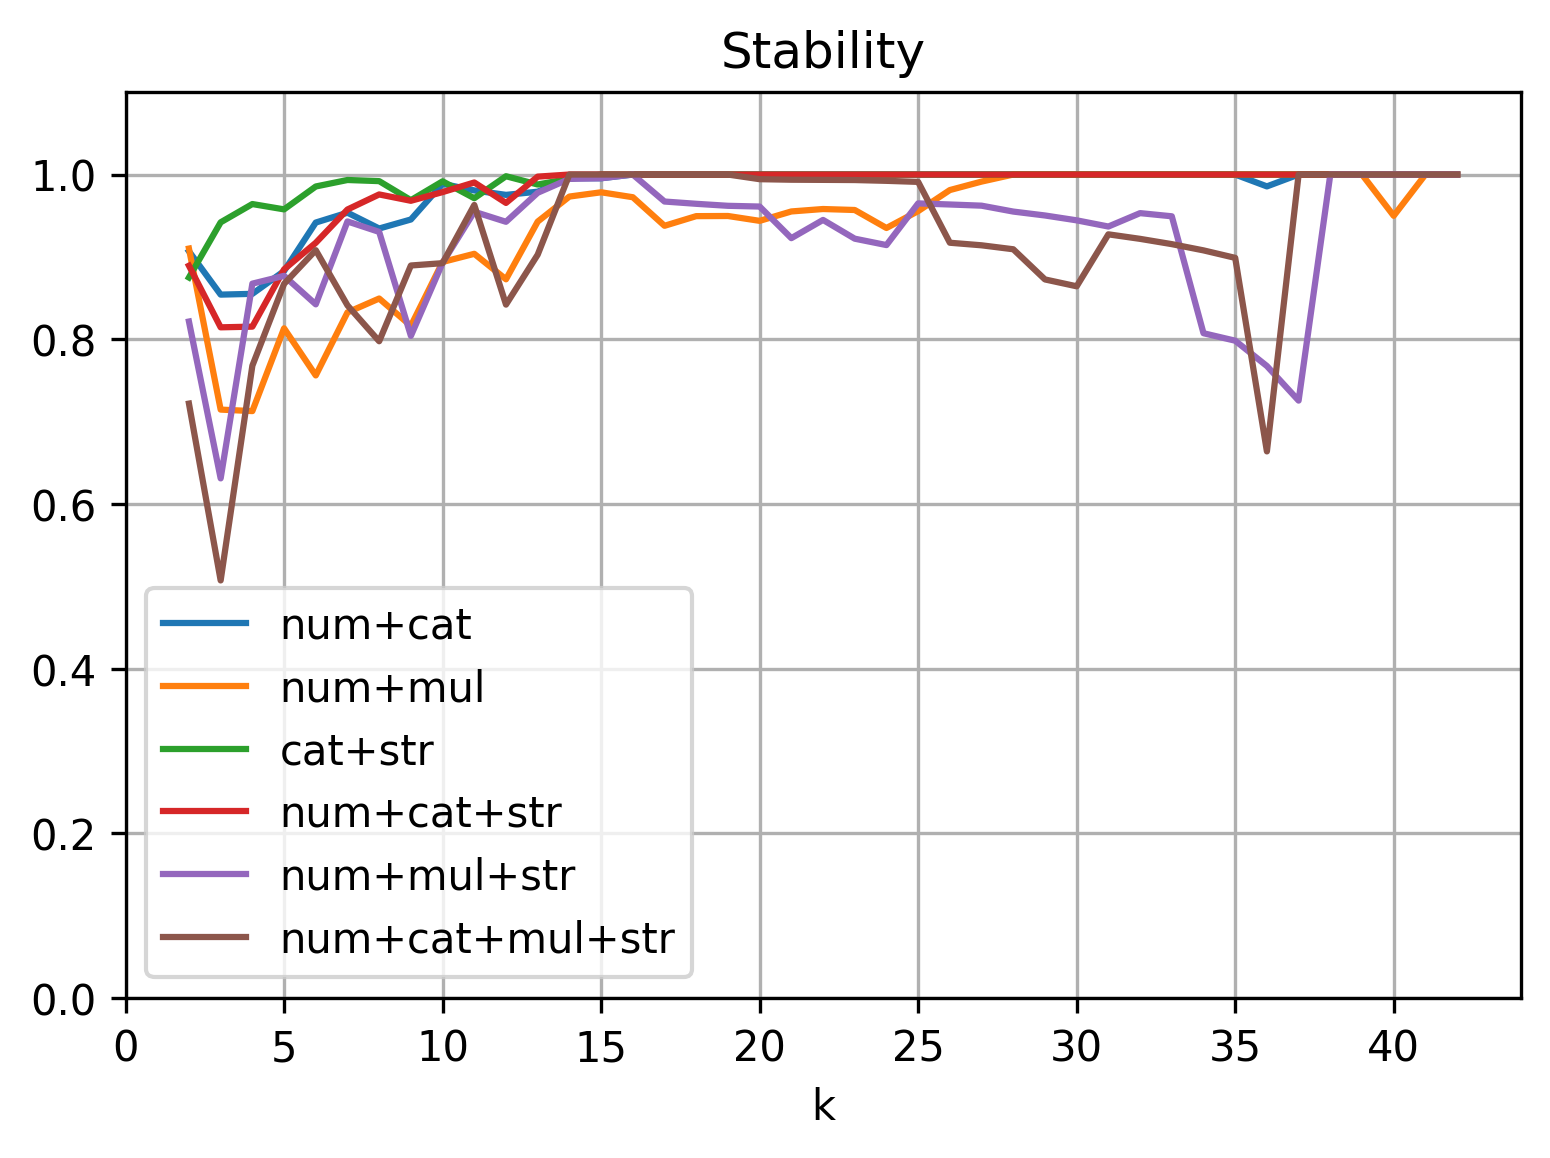

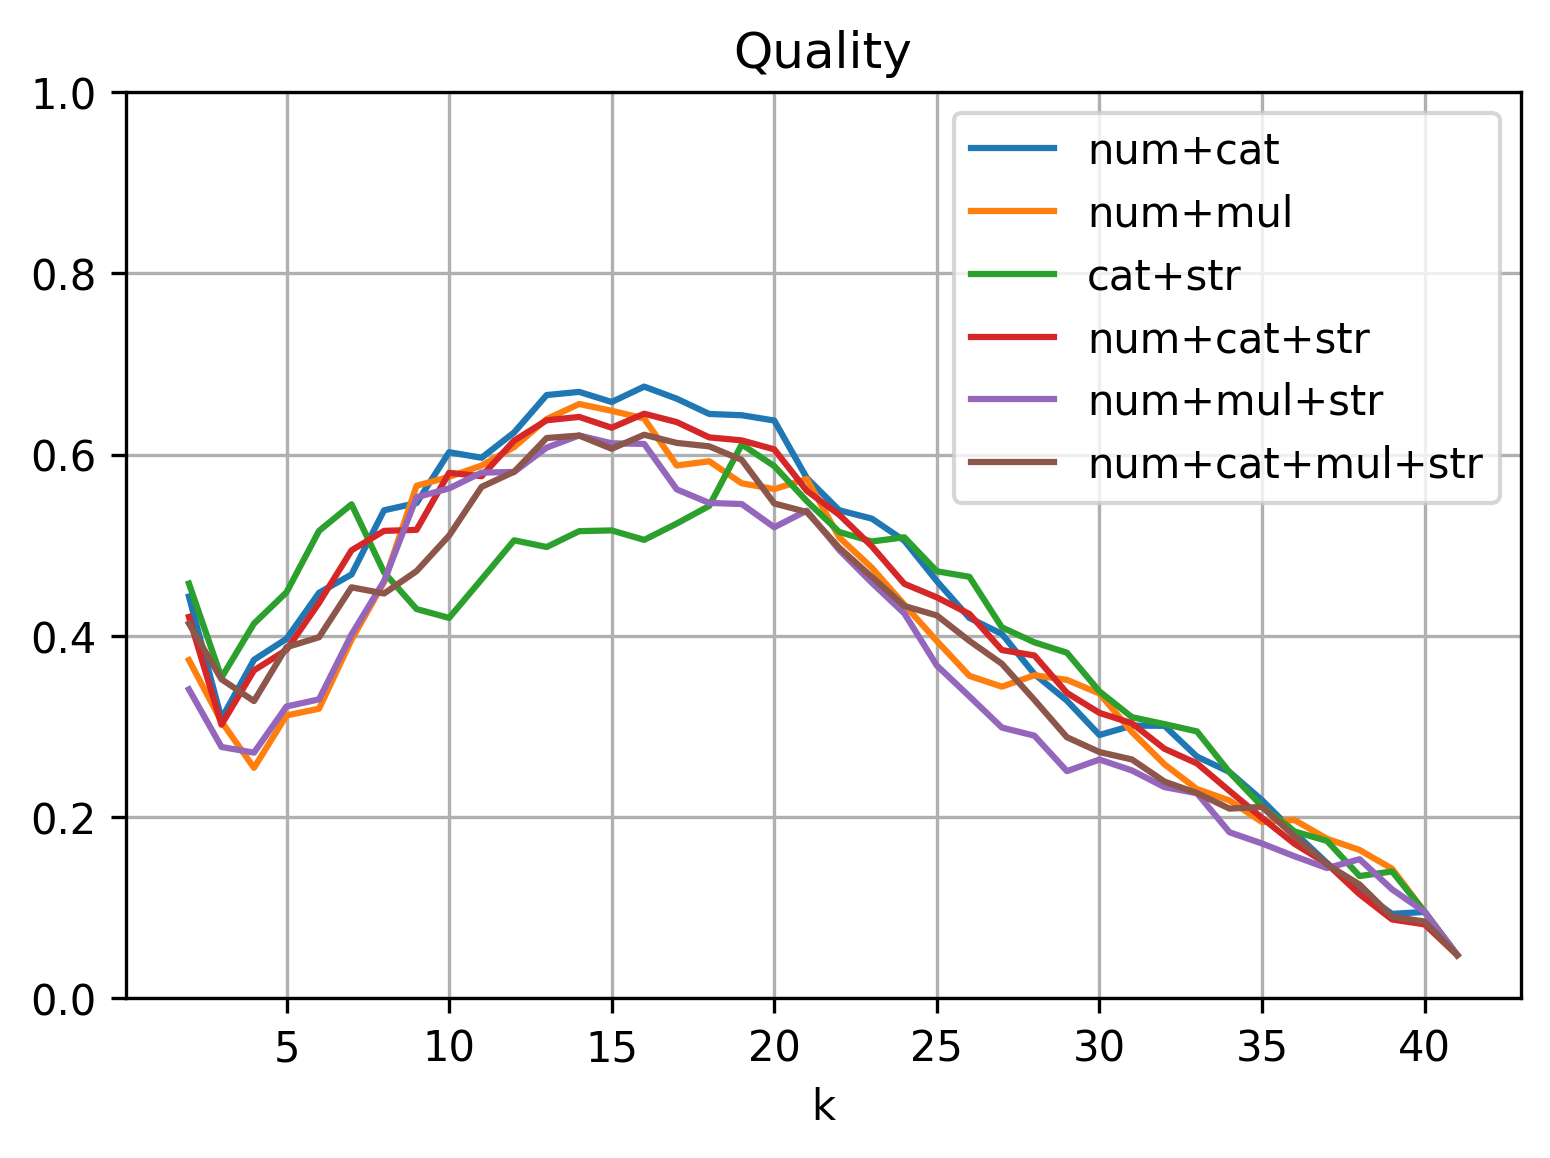

In [26]:
combis = ["num+cat", "num+mul", "cat+str", "num+cat+str", "num+mul+str", "num+cat+mul+str"]

pd.DataFrame({
    key: metrics_types[key]["stabilities"]
    for key in combis
}, index=range(2, n+1)).plot.line(title="Stability", ylim=(0,1.1), xlabel="k", grid=True)
pd.DataFrame({
    key: metrics_types[key]["qualities"]
    for key in combis
}, index=range(2, n)).plot.line( title="Quality", ylim=(0,1), xlabel="k", grid=True)

### Evaluate Attribute Selection

#### Required

In [146]:
def metrics_types_req_make():
    return {
        key: calc_metrics(list(filter(lambda a: a in attr_req, codes)))
        for key, codes in attr_codes_types.items()
    }
metrics_types_req = config.load_or_create(data_dir / "metrics-types-req.pkl", metrics_types_req_make)

In [147]:
pd.DataFrame({
    f"{key} req": metrics_to_table(values)
    for key, values in metrics_types_req.items()
}).transpose().round(2)

,Stability,Quality,Match Generations,Match Models,Match Duplicates
numerical req,0.96,0.48,-0.04,0.48,0.97
categorical req,0.76,0.44,0.55,0.46,0.75
multi req,0.70,0.38,0.51,0.24,0.86
string req,0.94,0.37,0.17,0.53,0.96
num+cat req,0.91,0.42,-0.04,0.61,0.89
num+mul req,0.91,0.31,0.07,0.52,1.00
num+str req,1.00,0.40,-0.04,0.83,0.97
cat+mul req,0.73,0.29,0.57,0.58,0.94
cat+str req,0.93,0.36,0.47,0.54,0.90
mul+str req,0.91,0.25,0.62,0.35,0.94


In [148]:
types = ["numerical", "categorical", "multi", "string", "num+cat", "num+cat+str", "num+cat+mul+str"]
tmp = {}
for key in types:
    tmp[f"{key}"] = metrics_to_table(metrics_types[key])
    tmp[f"{key} req"] = metrics_to_table(metrics_types_req[key])
pd.DataFrame(tmp).transpose().round(2)

,Stability,Quality,Match Generations,Match Models,Match Duplicates
numerical,0.88,0.43,0.01,0.75,0.96
numerical req,0.96,0.48,-0.04,0.48,0.97
categorical,0.96,0.45,0.65,0.49,0.81
categorical req,0.76,0.44,0.55,0.46,0.75
multi,0.91,0.39,0.40,0.45,0.89
multi req,0.70,0.38,0.51,0.24,0.86
string,0.91,0.34,0.64,0.87,1.00
string req,0.94,0.37,0.17,0.53,0.96
num+cat,0.98,0.43,0.65,0.71,0.96
num+cat req,0.91,0.42,-0.04,0.61,0.89


,Stability,Quality,Match Generations,Match Models,Match Duplicates
num+cat,0.98,0.43,0.65,0.71,0.96
num+cat req,0.91,0.42,-0.04,0.61,0.89
num+cat opt,0.93,0.45,0.65,0.60,0.94


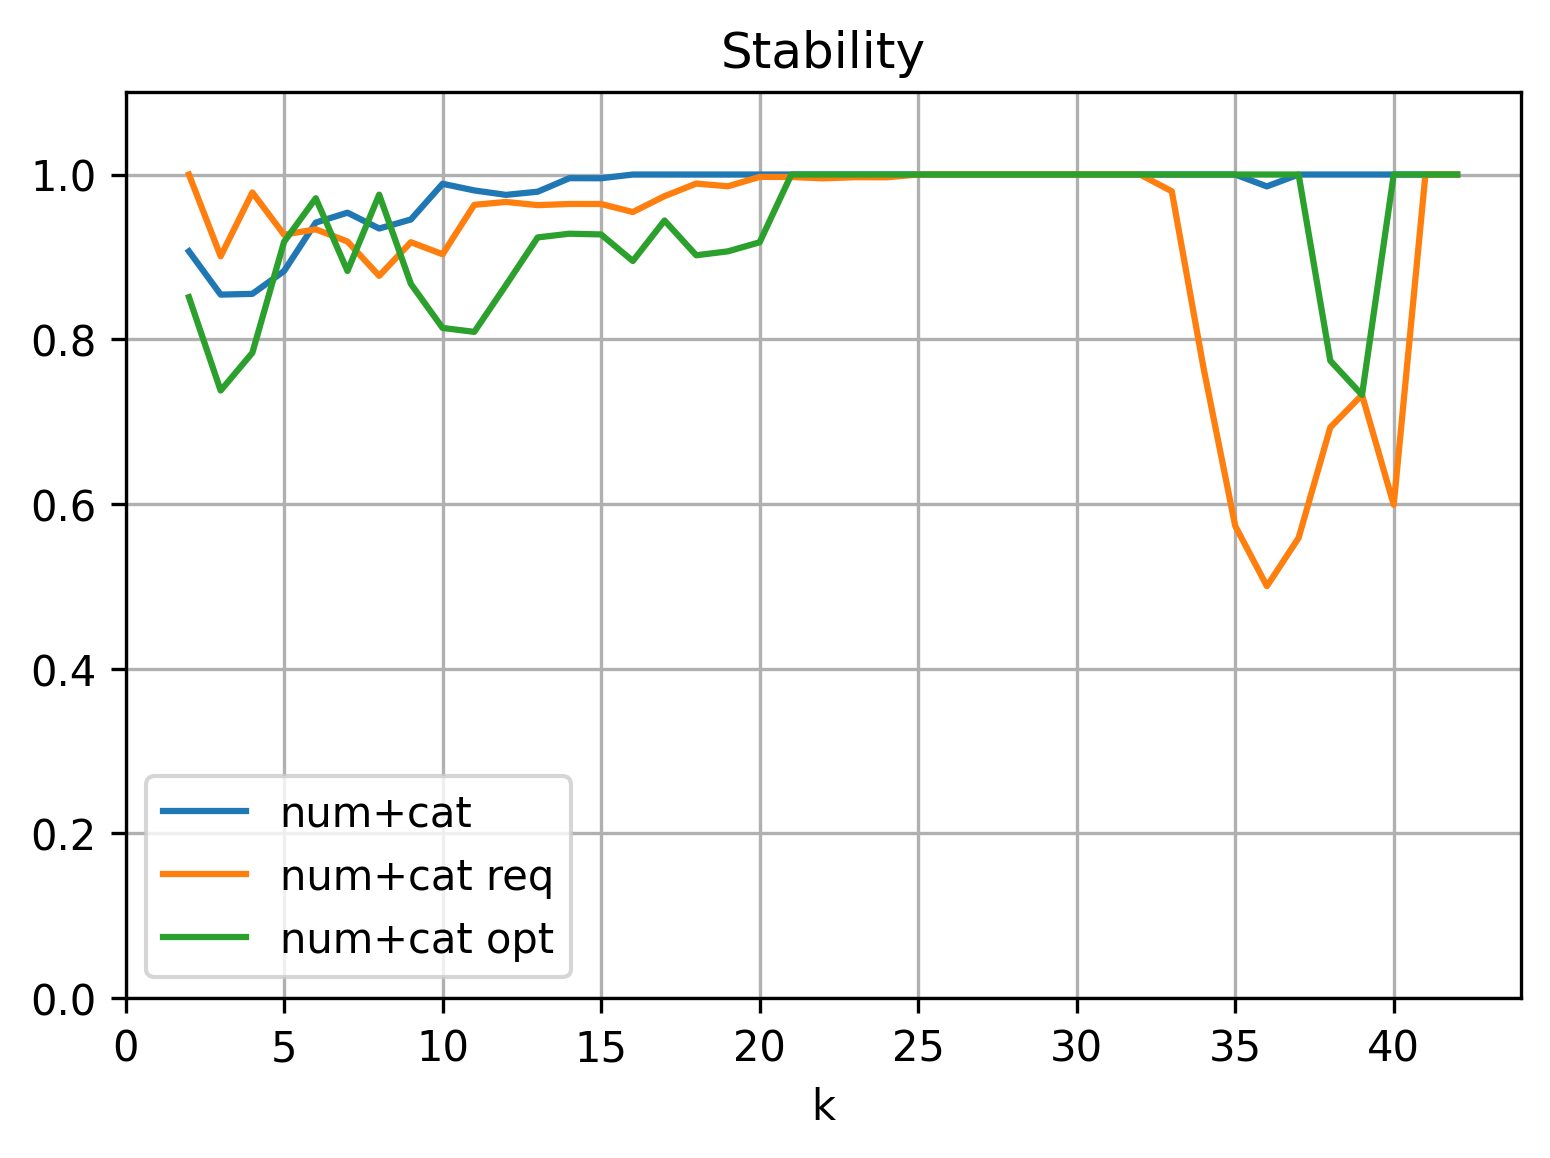

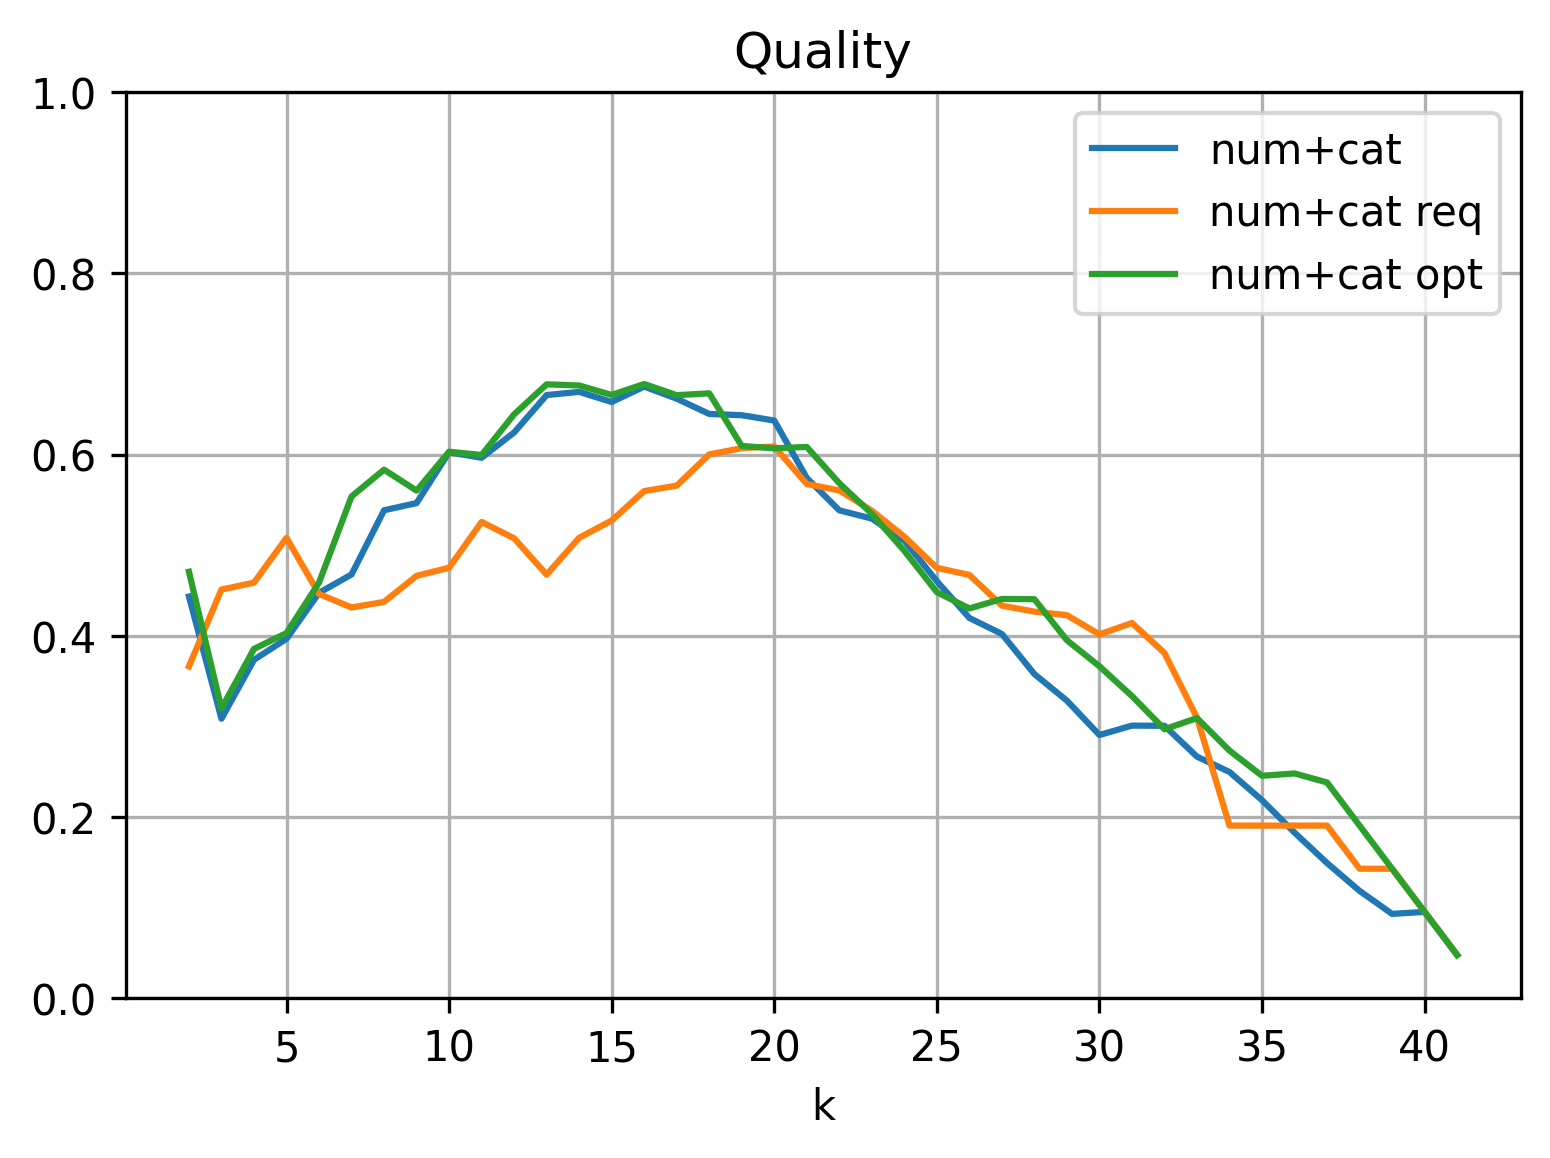

In [149]:
metrics_num_cat_opt = calc_metrics(list(filter(lambda a: a not in attr_req, attr_codes_types["num+cat"])))

pd.DataFrame({
    "num+cat": metrics_types["num+cat"]["stabilities"],
    "num+cat req": metrics_types_req["num+cat"]["stabilities"],
    "num+cat opt": metrics_num_cat_opt["stabilities"],
}, index=range(2, n+1)).plot.line( title="Stability", ylim=(0,1.1), xlabel="k", grid=True)
pd.DataFrame({
    "num+cat": metrics_types["num+cat"]["qualities"],
    "num+cat req": metrics_types_req["num+cat"]["qualities"],
    "num+cat opt": metrics_num_cat_opt["qualities"],
}, index=range(2, n)).plot.line( title="Quality", ylim=(0,1), xlabel="k", grid=True)
pd.DataFrame({
    "num+cat": metrics_to_table(metrics_types["num+cat"]),
    "num+cat req": metrics_to_table(metrics_types_req["num+cat"]),
    "num+cat opt": metrics_to_table(metrics_num_cat_opt),
}).transpose().round(2)

#### Custom Selection

In [150]:
def metrics_attr_make():
    return {
        attr_code: calc_metrics([attr_code])
        for attr_code in attr_df["code"]
    }
metrics_attr = config.load_or_create(data_dir / "metrics-attr.pkl", metrics_attr_make)

In [151]:
tmp_df = pd.DataFrame({
    key: metrics_to_table(values)
    for key, values in metrics_attr.items()
}).transpose()

tmp = pd.concat([
    tmp_df.sort_values("Stability", ascending=False).head(5),
    tmp_df.sort_values("Quality", ascending=False).head(5),
    tmp_df.sort_values("Match Generations", ascending=False).head(5),
    tmp_df.sort_values("Match Models", ascending=False).head(5),
    tmp_df.sort_values("Match Duplicates", ascending=False).head(5),
]).drop_duplicates()
tmp.style.highlight_max(color="lightgreen")

,Stability,Quality,Match Generations,Match Models,Match Duplicates
icecat_summary_short,0.943609,0.285879,-0.028991,0.577070,0.966667
icecat_13246_fixed,0.938158,0.560910,0.154585,0.740245,0.891667
icecat_title,0.915494,0.288619,0.279755,0.562973,0.958333
icecat_1464,0.889745,0.518614,-0.030165,0.626484,0.819444
icecat_94,0.881932,0.532151,-0.006147,0.874569,0.891667
icecat_1649,0.688463,0.503897,-0.020937,0.667901,0.841667
icecat_17669_fixed,0.782693,0.488772,0.074541,0.481460,0.891667
icecat_11417,0.601428,0.292923,0.891283,0.235093,0.750000
icecat_7021,0.338374,0.263095,0.752675,0.151649,0.694444
icecat_17956,0.776030,0.421385,0.686679,0.250104,0.825000


In [152]:
attr_codes_high_impact = ["icecat_13246_fixed", "icecat_summary_short", "icecat_94", "icecat_11417"]
attr_df[attr_df["code"].isin(attr_codes_high_impact)]

,code,name,type,typeclass,required,non-null,unique
5,icecat_11417,Native aspect ratio,AttributeType.SELECT_SINGLE,categorical,False,19,3
13,icecat_13246_fixed,Pixel density,AttributeType.NUMBER,numerical,False,37,11
184,icecat_94,Weight,AttributeType.METRIC,numerical,True,40,11
193,icecat_summary_short,Short Summary,AttributeType.TEXT,string,True,42,38


In [18]:
attr_df[
    attr_df["unique"] > 1
].sort_values("non-null", ascending=False).head(50)

,code,name,type,typeclass,required,non-null,unique
90,icecat_35935_fixed,Third rear camera resolution (numeric),AttributeType.NUMBER,numerical,False,42,5
25,icecat_1585,Display resolution,AttributeType.TEXT,string,True,42,4
193,icecat_summary_short,Short Summary,AttributeType.TEXT,string,True,42,38
192,icecat_name,Name,AttributeType.TEXT,string,True,42,24
185,icecat_944,Display diagonal,AttributeType.METRIC,numerical,True,42,8
180,icecat_9104,Display type,AttributeType.SELECT_SINGLE,categorical,False,42,2
178,icecat_909,Battery capacity,AttributeType.METRIC,numerical,True,42,5
170,icecat_8730,Internal storage capacity,AttributeType.METRIC,numerical,True,42,3
65,icecat_27588_fixed,Second rear camera resolution (numeric),AttributeType.NUMBER,numerical,False,42,3
64,icecat_27587,Rear camera type,AttributeType.SELECT_SINGLE,categorical,True,42,2


In [154]:
akeneo.Attribute.to_dict(cache.attributes)["icecat_3233"].options

[AttributeOption(code='220417013', labels={'en_US': 'Windows 10 Mobile', 'en_GB': 'Windows 10 Mobile', 'de_DE': 'Windows 10 Mobile'}, attribute='icecat_3233', sort_order=3),
 AttributeOption(code='349662345', labels={'en_US': 'Android 10.0', 'en_GB': 'Android 10.0', 'de_DE': 'Android 10.0'}, attribute='icecat_3233', sort_order=0),
 AttributeOption(code='400403567', labels={'en_US': 'Android 11', 'en_GB': 'Android 11', 'de_DE': 'Android 11'}, attribute='icecat_3233', sort_order=1),
 AttributeOption(code='458962783', labels={'en_US': 'Android 12', 'en_GB': 'Android 12', 'de_DE': 'Android 12'}, attribute='icecat_3233', sort_order=2)]

In [155]:
products_df[["icecat_75_fixed", "icecat_3233"]].drop_duplicates()

,icecat_75_fixed,icecat_3233
0,android,349662345
14,android,NaN
18,android,400403567
34,NaN,NaN
39,android,458962783


In [156]:
attr_codes_selection = [
    # aspect, pixel density, display diagonal
    "icecat_13246_fixed",
    "icecat_11417",
    "icecat_944",
    # weight, h x w x d
    "icecat_94",
    "icecat_1464",
    "icecat_1649",
    "icecat_1650",
    # camera
    "icecat_12435_fixed",
    "icecat_12437_fixed",
    # mobile generation
    "icecat_40629",
    # platform, os installed
    "icecat_75_fixed",
    "icecat_3233",
    # title
    "icecat_title",
]
attr_df[attr_df["code"].isin(attr_codes_selection)]

,code,name,type,typeclass,required,non-null,unique
5,icecat_11417,Native aspect ratio,AttributeType.SELECT_SINGLE,categorical,False,19,3
10,icecat_12435_fixed,Rear camera resolution (numeric),AttributeType.NUMBER,numerical,True,42,4
11,icecat_12437_fixed,Front camera resolution (numeric),AttributeType.NUMBER,numerical,True,42,3
13,icecat_13246_fixed,Pixel density,AttributeType.NUMBER,numerical,False,37,11
17,icecat_1464,Height,AttributeType.METRIC,numerical,False,40,11
29,icecat_1649,Width,AttributeType.METRIC,numerical,False,40,8
30,icecat_1650,Depth,AttributeType.METRIC,numerical,False,40,7
76,icecat_3233,Operating system installed,AttributeType.SELECT_SINGLE,categorical,True,36,3
120,icecat_40629,Mobile network generation,AttributeType.SELECT_SINGLE,categorical,True,40,2
152,icecat_75_fixed,Platform,AttributeType.SELECT_SINGLE,categorical,True,40,1


In [157]:
def metrics_selection_make():
    return {
        "high impact": calc_metrics(attr_codes_high_impact),
        "selection": calc_metrics(attr_codes_selection),
    }
metrics_selection = config.load_or_create(data_dir / "metrics-selection.pkl", metrics_selection_make)

In [158]:
pd.DataFrame({
    "num+cat": metrics_to_table(metrics_types["num+cat"]),
    **{
        key: metrics_to_table(values)
        for key, values in metrics_selection.items()
    },
}).transpose().round(2)

,Stability,Quality,Match Generations,Match Models,Match Duplicates
num+cat,0.98,0.43,0.65,0.71,0.96
high impact,0.93,0.39,0.33,0.63,0.97
selection,0.93,0.44,0.30,0.77,0.96


<AxesSubplot:title={'center':'Quality'}, xlabel='k'>

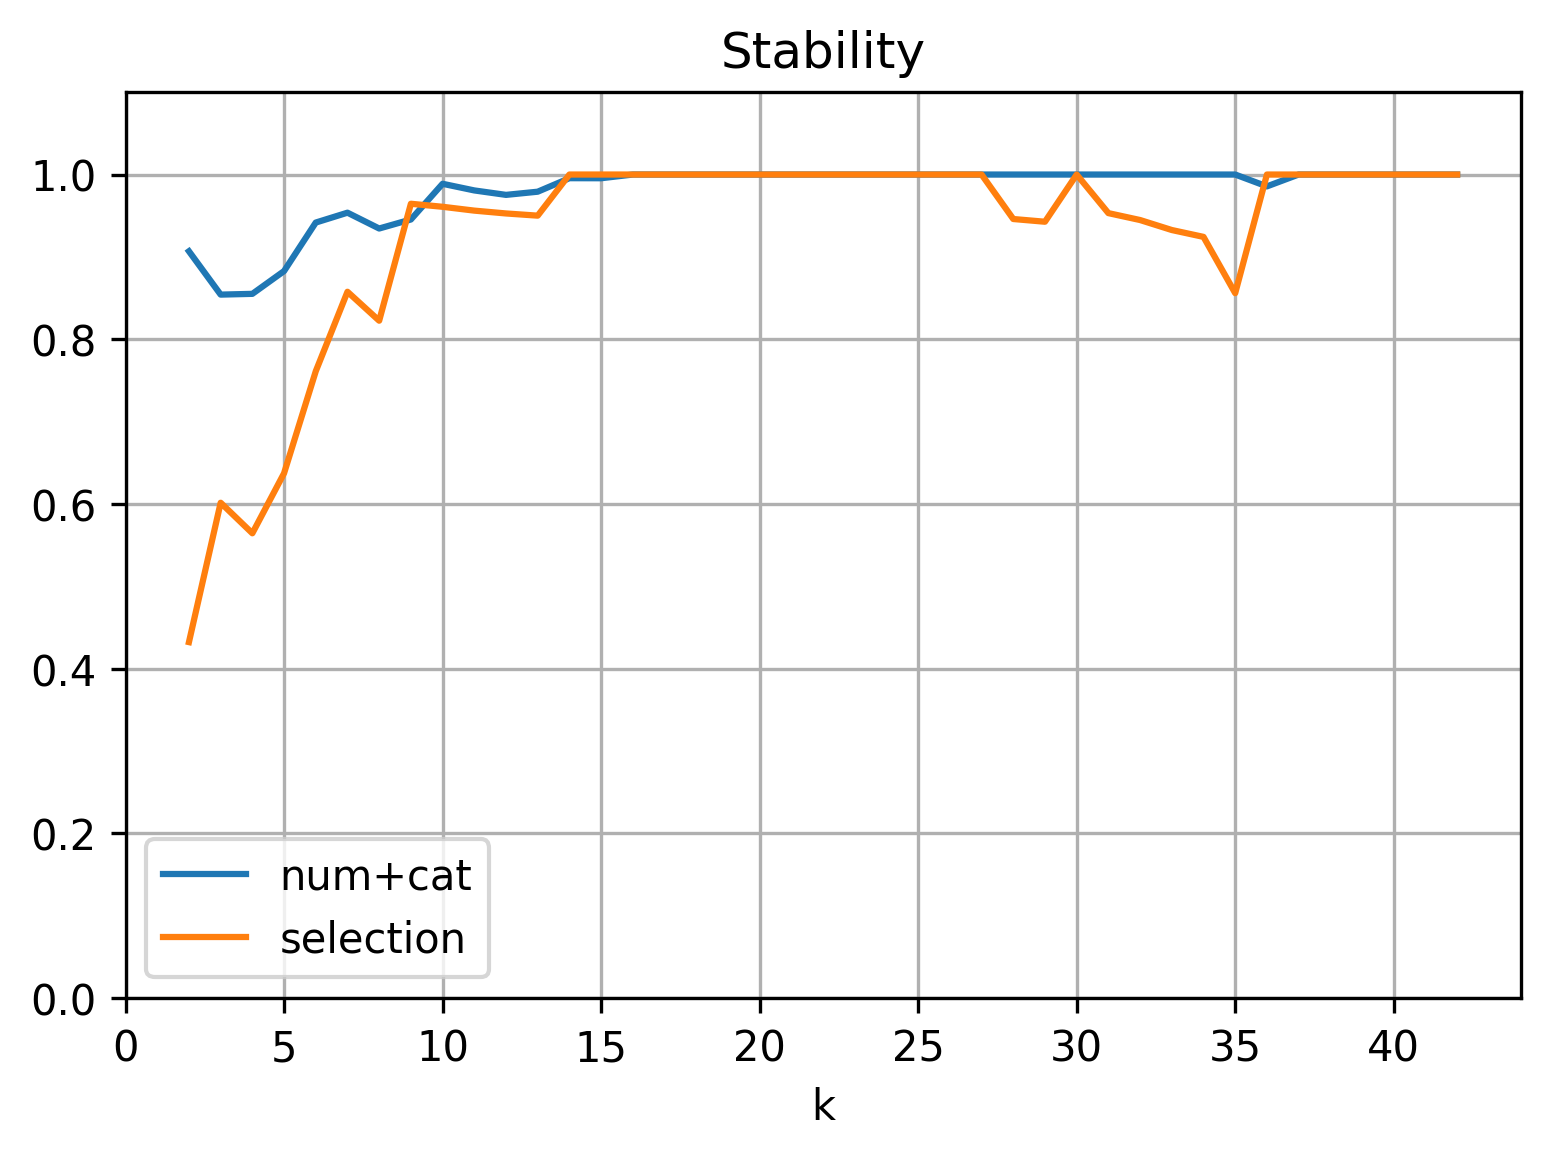

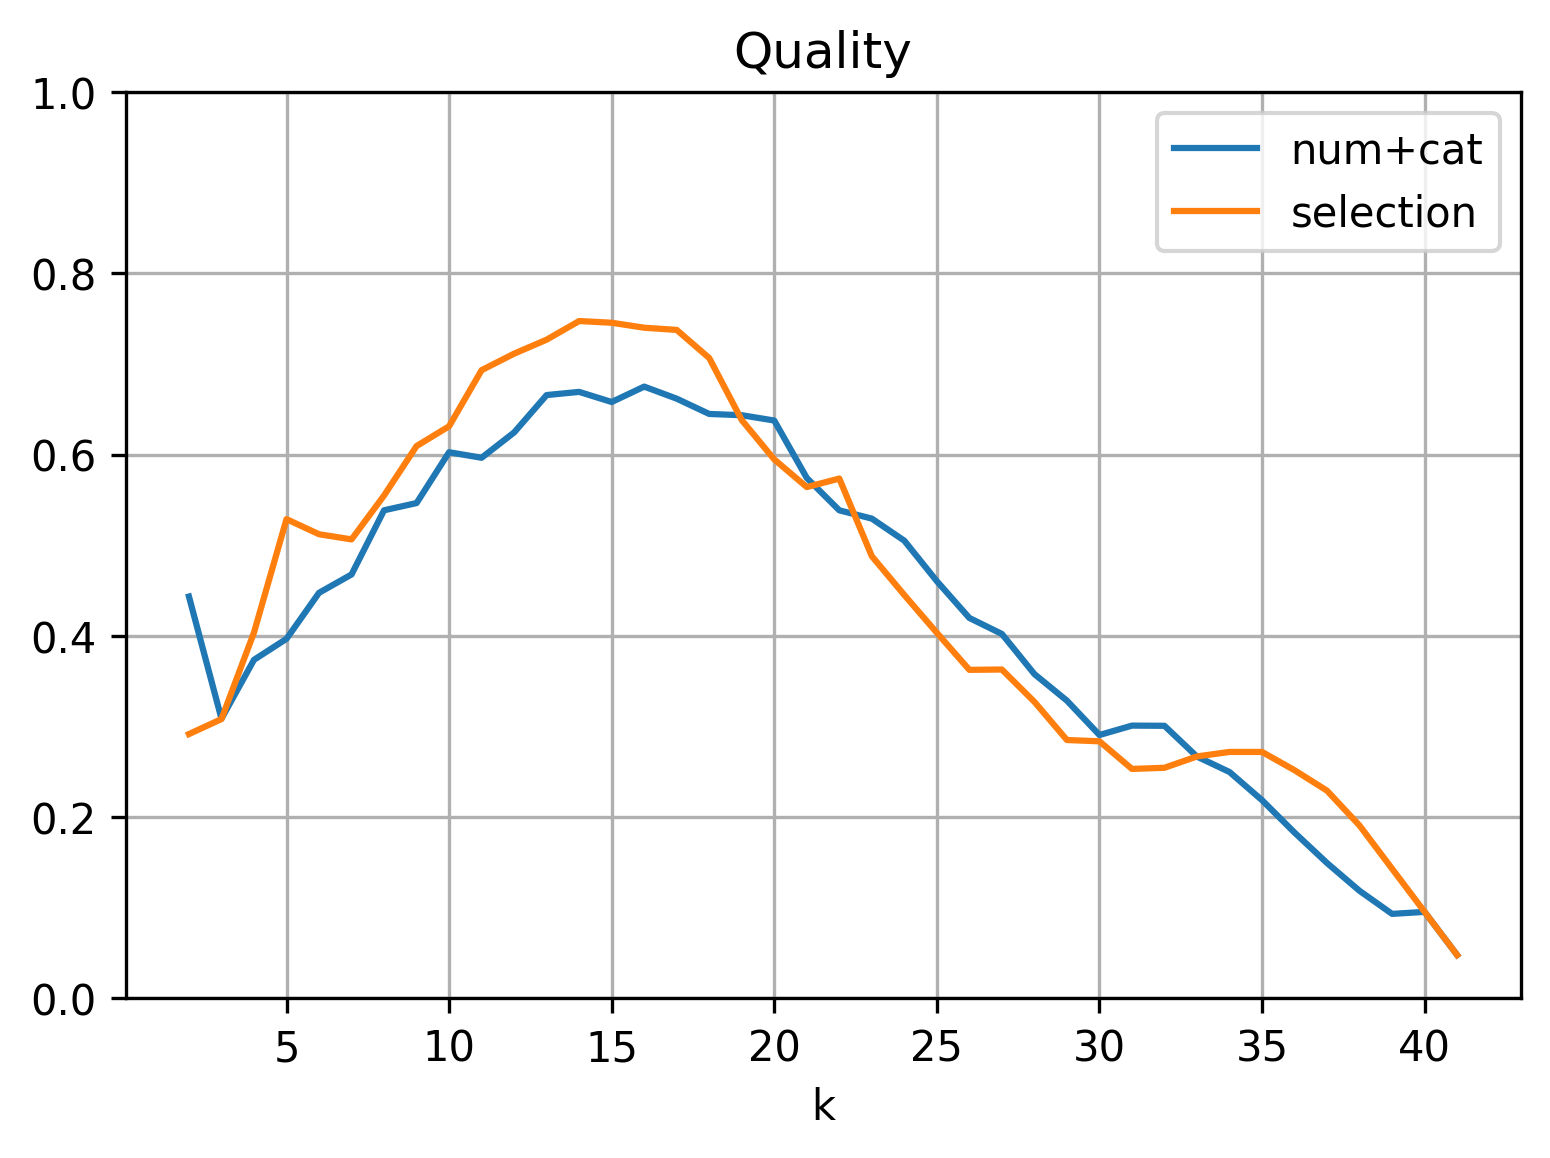

In [159]:
pd.DataFrame({
    "num+cat": metrics_types["num+cat"]["stabilities"],
    "selection": metrics_selection["selection"]["stabilities"],
}, index=range(2, n+1)).plot.line(title="Stability", ylim=(0,1.1), xlabel="k", grid=True)
pd.DataFrame({
    "num+cat": metrics_types["num+cat"]["qualities"],
    "selection": metrics_selection["selection"]["qualities"],
}, index=range(2, n)).plot.line( title="Quality", ylim=(0,1), xlabel="k", grid=True)

### Evaluate Attribute Weight

In [160]:
def metrics_overweight_make():
    return {
        "all & selection x2": calc_metrics(attr_codes_types["num+cat+mul+str"], False, attr_codes_selection, 2),
        "all & selection x3": calc_metrics(attr_codes_types["num+cat+mul+str"], False, attr_codes_selection, 3),
        "num+cat & selection x2": calc_metrics(attr_codes_types["num+cat"], False, attr_codes_selection, 2),
        "num+cat & selection x3": calc_metrics(attr_codes_types["num+cat"], False, attr_codes_selection, 3),
        "num+cat+selection": calc_metrics(
            pd.Series(attr_codes_types["num+cat"]+attr_codes_selection).drop_duplicates().to_list()
        )
    }
metrics_overweight = config.load_or_create(data_dir / "metrics-overweight.pkl", metrics_overweight_make)

In [161]:
pd.DataFrame({
    "num+cat": metrics_to_table(metrics_types["num+cat"]),
    **{
        key: metrics_to_table(values)
        for key, values in metrics_overweight.items()
    },
}).transpose().round(2)

,Stability,Quality,Match Generations,Match Models,Match Duplicates
num+cat,0.98,0.43,0.65,0.71,0.96
all & selection x2,0.95,0.39,0.72,0.70,1.00
all & selection x3,0.94,0.39,0.72,0.70,1.00
num+cat & selection x2,0.96,0.42,0.52,0.73,0.96
num+cat & selection x3,0.93,0.41,0.52,0.67,0.97
num+cat+selection,0.95,0.43,0.65,0.71,0.96


<AxesSubplot:title={'center':'Quality'}, xlabel='k'>

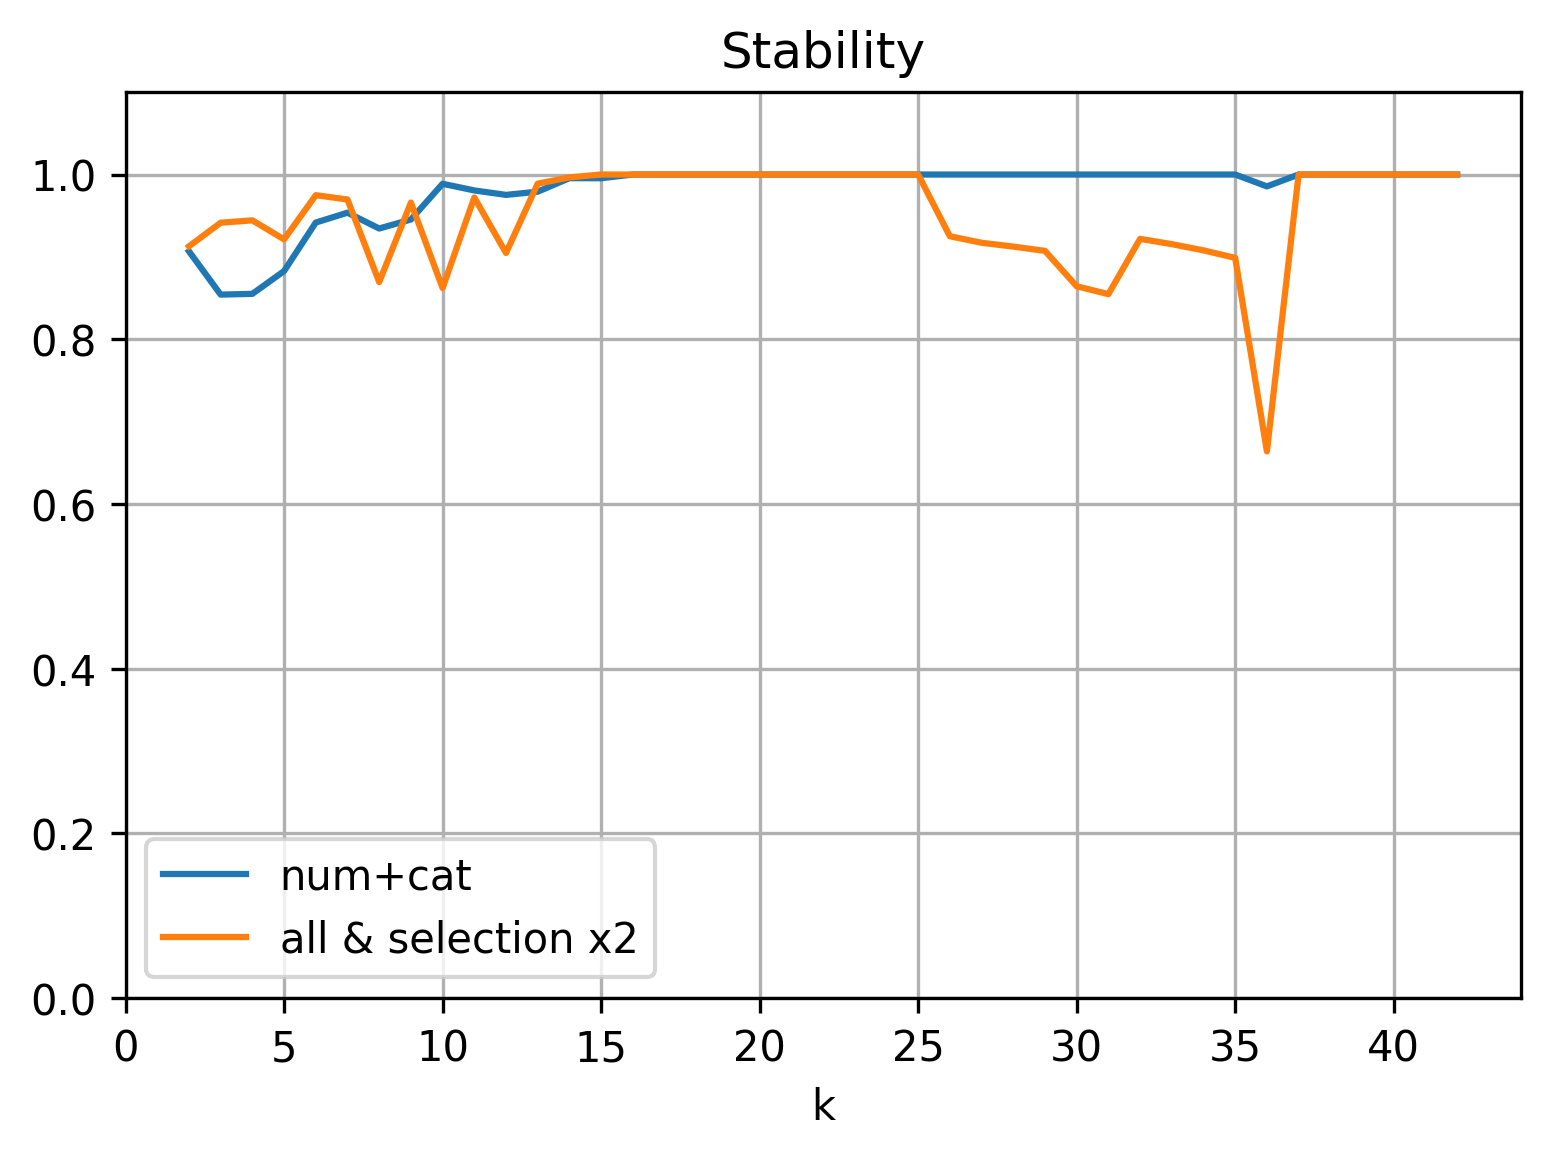

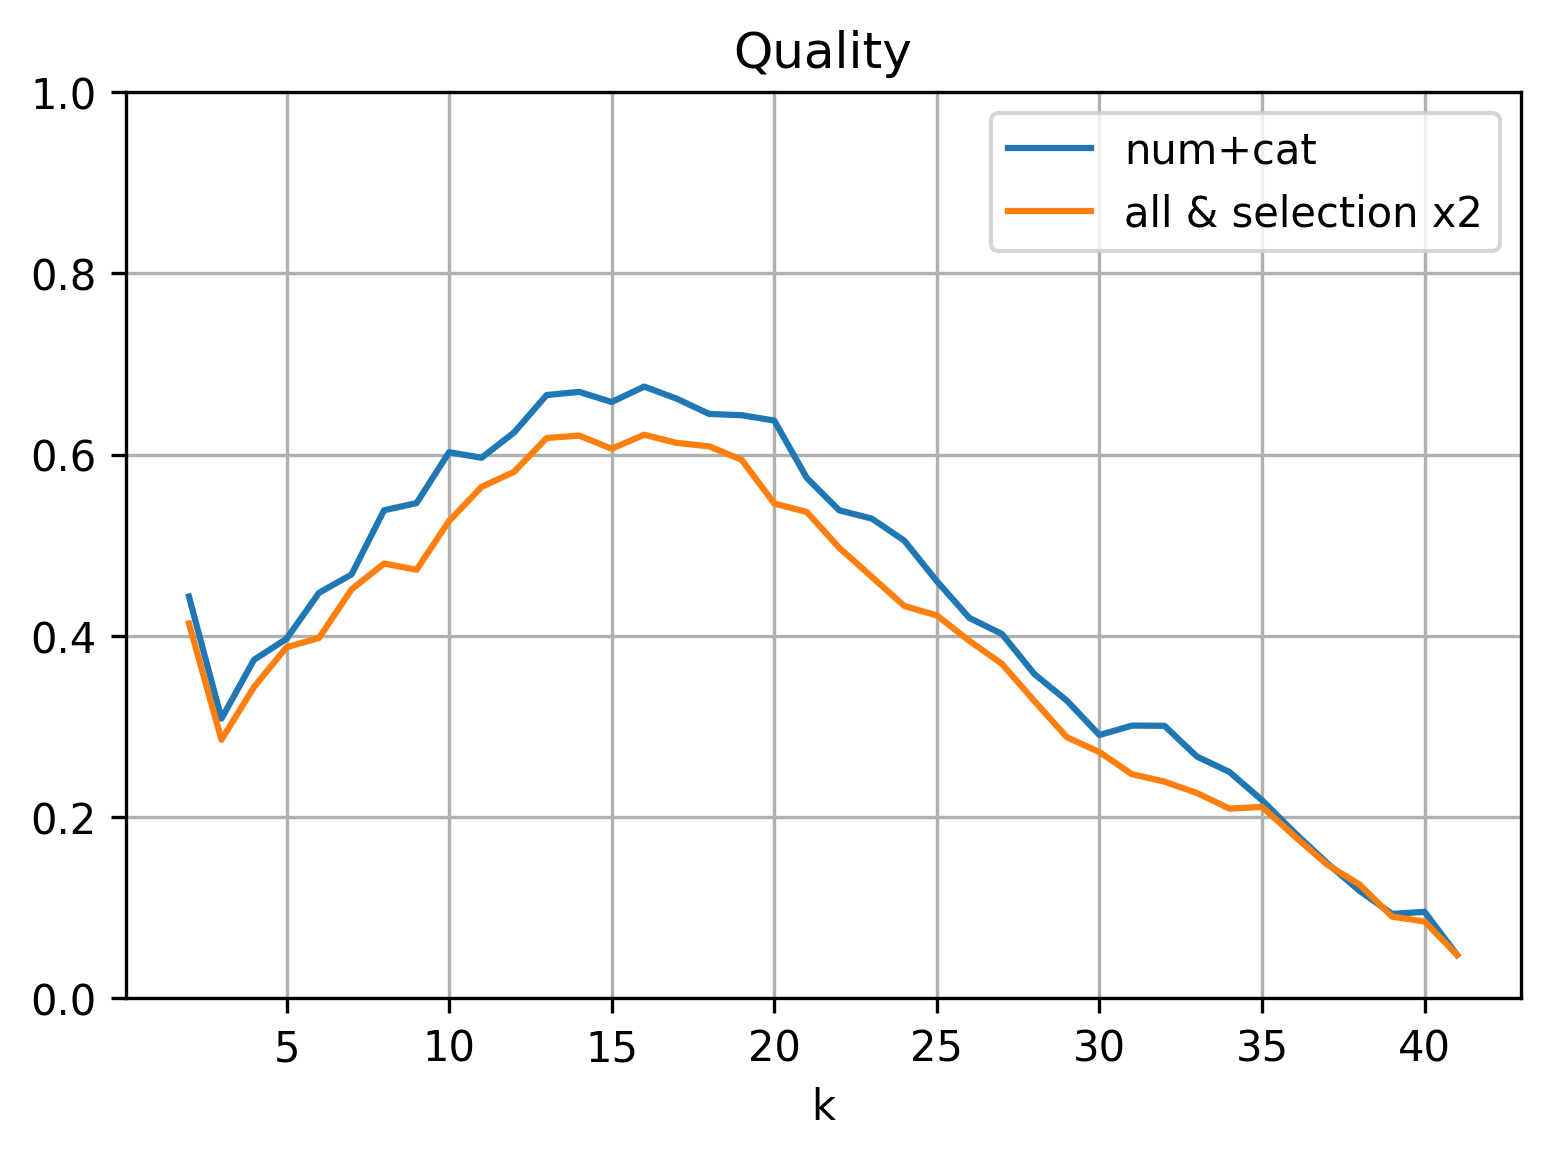

In [162]:
pd.DataFrame({
    "num+cat": metrics_types["num+cat"]["stabilities"],
    "all & selection x2": metrics_overweight["all & selection x2"]["stabilities"],
}, index=range(2, n+1)).plot.line(title="Stability", ylim=(0,1.1), xlabel="k", grid=True)
pd.DataFrame({
    "num+cat": metrics_types["num+cat"]["qualities"],
    "all & selection x2": metrics_overweight["all & selection x2"]["qualities"],
}, index=range(2, n)).plot.line( title="Quality", ylim=(0,1), xlabel="k", grid=True)

## Sonstiges